# Decision Tree & Random Forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('Dataset/train_preprocessing.csv')
test = pd.read_csv('Dataset/test_preprocessing.csv')
gender_submission = pd.read_csv('Dataset/gender_submission.csv')
# Merge the test dataframe with the gender_submission dataframe on 'PassengerId'
test = pd.merge(test, gender_submission[['PassengerId', 'Survived']], on='PassengerId', how='left')
test = test.drop(['Survived_x'], axis = 1)
test.rename(columns={'Survived_y': 'Survived'}, inplace=True)
print(test.head())
train = train[train['Survived'] != 'U']
test = test[test['Survived'] != 'U']
validation, test = train_test_split(test, test_size=2/3, random_state=42)

In [4]:
X_train = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_train = train[['Survived']].values
X_test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_test = test[['Survived']].values
X_valid = validation[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_valid = validation[['Survived']].values

In [2]:
def evaluate(Y_test, Y_pred_float, flag=0):
    precision = precision_score(Y_test, Y_pred_float, average='weighted')
    recall = recall_score(Y_test, Y_pred_float, average='weighted')
    f1 = f1_score(Y_test, Y_pred_float, average='weighted')
    # Confusion Matrix
    if flag:
        conf_matrix = confusion_matrix(Y_test, Y_pred_float)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # Precision
        print("Precision:", precision)

        # Recall
        print("Recall:", recall)

        # F1 Score
        print("F1 Score:", f1)

### Decision Tree and Random Forest 

In [ ]:
# Decision Tree
Tree = tree.DecisionTreeClassifier()
Tree.fit(X_train, Y_train)
Y_pred = Tree.predict(X_test)
evaluate(Y_test, Y_pred.astype(float),1)

In [ ]:
# Random Forest
best_model = None
f1 = []
max_f1 = -1e9
for i in range(1,51):
    model = RandomForestClassifier(n_estimators=i)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_valid)
    Y_pred_float = Y_pred.astype(float)
    f1_tmp = f1_score(Y_valid, Y_pred_float, average='weighted')
    f1.append(f1_tmp)
    if (f1_tmp > max_f1):
        max_f1 = f1_tmp
        best_model = model

plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), f1, label='F1')
plt.title('Tuning Result')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Y_pred = best_model.predict(X_test)
evaluate(Y_test, Y_pred.astype(float), 1)
    

### Scratch

Build the model

In [36]:
class TreeNode(object):
    def __init__(self, ids = None, children = [], entropy = 0, depth = 0):
        self.ids = ids           # index of data in this node
        self.entropy = entropy   # entropy, will fill later
        self.depth = depth       # distance to root node
        self.split_attribute = None # which attribute is chosen, it non-leaf
        self.children = children # list of its child nodes
        self.order = None       # order of values of split_attribute in children
        self.label = None       # label of node if it is a leaf

    def set_properties(self, split_attribute, order):
        self.split_attribute = split_attribute
        self.order = order

    def set_label(self, label):
        self.label = label


def entropy(freq):
    # remove prob 0 
    freq_0 = freq[np.array(freq).nonzero()[0]]
    prob_0 = freq_0/float(freq_0.sum())
    return -np.sum(prob_0*np.log(prob_0))

class DecisionTreeID3(object):
    def __init__(self, max_depth= 10, min_samples_split = 2, min_gain = 1e-4):
        self.root = None
        self.max_depth = max_depth 
        self.min_samples_split = min_samples_split 
        self.Ntrain = 0
        self.min_gain = min_gain
    
    def fit(self, data, target):
        self.Ntrain = data.count()[0]
        self.data = data 
        self.attributes = list(data)
        self.target = target 
        self.labels = target.unique()
        
        ids = range(self.Ntrain)
        self.root = TreeNode(ids = ids, entropy = self._entropy(ids), depth = 0)
        queue = [self.root]
        while queue:
            node = queue.pop()
            if node.depth < self.max_depth or node.entropy < self.min_gain:
                node.children = self._split(node)
                if not node.children: #leaf node
                    self._set_label(node)
                queue += node.children
            else:
                self._set_label(node)
                
    def _entropy(self, ids):
        # Calculate entropy for the node using the provided IDs.
        if len(ids) == 0:
            return 0
        freq = np.array(self.target.iloc[ids].value_counts())
        return entropy(freq)

    def _set_label(self, node):
        # Assign the most frequent label to a node.
        target_ids = node.ids
        node.set_label(self.target.iloc[target_ids].mode()[0])

    
    def _split(self, node):
        ids = node.ids 
        best_gain = 0
        best_splits = []
        best_attribute = None
        order = None
        sub_data = self.data.iloc[ids, :]
        for i, att in enumerate(self.attributes):
            values = self.data.iloc[ids, i].unique().tolist()
            if len(values) == 1: continue # entropy = 0
            splits = []
            for val in values: 
                sub_ids = sub_data.index[sub_data[att] == val].tolist()
                splits.append([sub_id-1 for sub_id in sub_ids])
            # don't split if a node has too small number of points
            if min(map(len, splits)) < self.min_samples_split: continue
            # information gain
            HxS= 0
            for split in splits:
                HxS += len(split)*self._entropy(split)/len(ids)
            gain = node.entropy - HxS 
            if gain < self.min_gain: continue # stop if small gain 
            if gain > best_gain:
                best_gain = gain 
                best_splits = splits
                best_attribute = att
                order = values
        node.set_properties(best_attribute, order)
        child_nodes = [TreeNode(ids = split,
                     entropy = self._entropy(split), depth = node.depth + 1) for split in best_splits]
        return child_nodes

    def predict(self, new_data):
        npoints = new_data.shape[0]
        labels = [None] * npoints

        for n in range(npoints):
            x = new_data.iloc[n, :]  # one point
            node = self.root

            while node.children:
                #print(f"Current Node Split Attribute: {node.split_attribute}")
                #print(f"Node Order: {node.order}")
                #print(f"Value in Test Data: {x[node.split_attribute]}")

                value = x[node.split_attribute]
                if value not in node.order:
                    #print(f"Value '{value}' not found in node order: {node.order}")
                    break
                node = node.children[node.order.index(value)]

            labels[n] = node.label if node.label is not None else None

        return labels

class RandomForest:
    def __init__(self, n_tree=3, max_depth=10, min_samples_split=2, min_gain=1e-4):
        self.n_tree = n_tree
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.trees = []

    def fit(self, X, Y):
        trees = []
        for i in range(self.n_tree):
            # Sample 70% of the data with replacement
            X_sub = X.sample(frac=0.7, replace=True, random_state=42 + i)
            indices = X_sub.index
            Y_sub = Y.loc[indices].reset_index(drop=True)
            X_sub = X_sub.reset_index(drop=True)
            
            # Initialize and fit a decision tree
            tree = DecisionTreeID3(max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_gain=self.min_gain)
            tree.fit(X_sub, Y_sub)
            trees.append(tree)
        
        self.trees = trees

    def predict(self, X):
        # Aggregate predictions from all trees
        predictions = np.zeros((X.shape[0], self.n_tree))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        
        # Replace NaN values with random 0s and 1s
        for i in range(predictions.shape[0]):
            for j in range(predictions.shape[1]):
                if np.isnan(predictions[i, j]):
                    predictions[i, j] = np.random.choice([0, 1])
        
        # Majority vote
        final_predictions = [np.bincount(predictions[i].astype(int)).argmax() for i in range(X.shape[0])]
        return final_predictions
    
            
        

Categorize the dataset

In [4]:
# Age
bins_age = [0, 18, 30, 50, np.inf]
labels_age = ['0-18', '18-30', '30-50', '50+']
train['Age'] = pd.cut(train['Age'], bins=bins_age, labels=labels_age, right=False)
# Fare
bins_fare = [0, 100, 200, 300, 400, 500, np.inf]
labels_fare = ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']
train['Fare'] = pd.cut(train['Fare'], bins=bins_fare, labels=labels_fare, right=False)


In [5]:
test['Age'] = pd.cut(test['Age'], bins=bins_age, labels=labels_age, right=False)
test['Fare'] = pd.cut(test['Fare'], bins=bins_fare, labels=labels_fare, right=False)
validation['Age'] = pd.cut(validation['Age'], bins=bins_age, labels=labels_age, right=False)
validation['Fare'] = pd.cut(validation['Fare'], bins=bins_fare, labels=labels_fare, right=False)

In [6]:
X_train = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']]
Y_train = train[['Survived']]
Y_train = Y_train.squeeze()
Y_train = pd.Series(Y_train.values, index=range(1, len(Y_train) + 1))
Y_train[Y_train == '1.0'] = 1
Y_train[Y_train == '0.0'] = 0
X_test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']]
Y_test = test[['Survived']]
Y_test = Y_test.squeeze()
Y_test = pd.Series(Y_test.values, index=range(1, len(Y_test) + 1))
X_valid = validation[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']]
Y_valid = validation[['Survived']]
Y_valid = Y_valid.squeeze()
Y_valid = pd.Series(Y_valid.values, index=range(1, len(Y_valid) + 1))
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
Y_valid = Y_valid.reset_index(drop=True)

In [ ]:
Y_train

In [ ]:
occur = [set() for _ in range(8)]
occur2 = [set() for _ in range(8)]
for _, i in X_train.iterrows():
    for j in range(8):
        if i.iloc[j] in occur[j]:
            continue
        else:
            occur[j].add(i.iloc[j])

for _, i in X_test.iterrows():
    for j in range(8):
        if i.iloc[j] in occur2[j]:
            continue
        else:
            occur2[j].add(i.iloc[j])
print(occur)
print(occur2)

In [ ]:
condition = X_test.iloc[:, 4] != 9
condition2 = X_valid.iloc[:, 4] != 9
X_test = X_test[condition].reset_index(drop=True)
Y_test = Y_test[condition].reset_index(drop=True)
X_valid = X_valid[condition2].reset_index(drop=True)
Y_valid = Y_valid[condition2].reset_index(drop=True)

In [ ]:
print(X_test)
print(X_train)

Modeling

In [ ]:
tree = DecisionTreeID3()
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
for i in range(len(Y_pred)):
    if Y_pred[i] == None:
        Y_pred[i] = 0
Y_pred_array = np.array(Y_pred, dtype='int64')
evaluate(Y_test, Y_pred, 1)


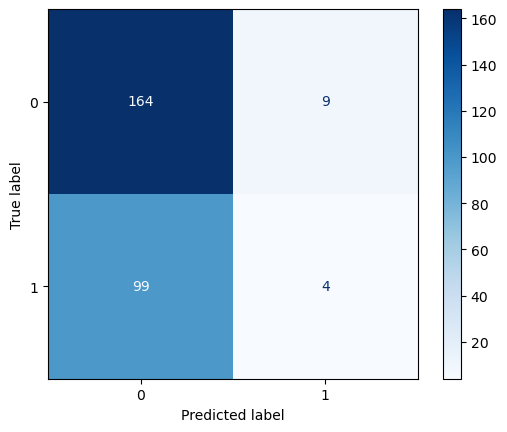

Precision: 0.5056907053931355
Recall: 0.6086956521739131
F1 Score: 0.4972834683575643


In [41]:
forest = RandomForest(n_tree=1)
forest.fit(X_train, Y_train)
Y_pred = forest.predict(X_test)
evaluate(Y_test, Y_pred, 1)